In [ ]:
!pip install -U tensorly teneva mlxtend --quiet

# 🧱 Compressing FC layer with Skeleton decomposition

## 💃 Let's train usual LeNet on FashionMNIST

In [ ]:
# import dependencies
import numpy as np # for scientific computation
import pandas as pd
import torch
import torchvision
from torch import nn # building blocks of a CNN
import matplotlib.pyplot as plt # ploting library
from torchvision.transforms import Resize, ToTensor , Normalize, Compose
import torch.optim as optim # optimizer algorithms package

from mlxtend.plotting import plot_confusion_matrix
import torch.nn.functional as F
import os
import time

torch.manual_seed(seed=59) # set seed for reproducibility
from sklearn.metrics import confusion_matrix

In [ ]:
# def helper functions
@torch.no_grad()
def get_all_preds(data_loader, model):
    """function to return all predicted probabilities"""
    all_preds = torch.tensor([]) # init empty tensor
    for batch in data_loader:
        imgs, lbls = batch
        preds = model(imgs)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds 

def get_correct(preds, lbls):
    """function tells us how many predictions are correct"""
    return preds.argmax(1).eq(lbls).sum().item()

In [ ]:
# prepare data & specify some transforms

batch_size = 256

transf = {
    "train":Compose([ToTensor(), 
                     Normalize(mean=0.3814, std=0.3994)]),
     "val": Compose([ToTensor(), Normalize(mean=0.3814, std=0.3994)])
             }

root_dir = "../../OOP"
train_data = torchvision.datasets.FashionMNIST(root=root_dir, train=True,
                                               transform=transf['train'], 
                                               download=True )

val_data = torchvision.datasets.FashionMNIST(root=root_dir, train=False,
                                               transform=transf['val'], 
                                               download=True )



# train dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True, num_workers=1)

# test dataloaders
train_test_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False, num_workers=1)
val_test_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False, num_workers=1)

In [ ]:
# define LeNet-5
lenet = nn.Sequential()
lenet.add_module("conv1", nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2))
lenet.add_module("tanh1", nn.Tanh())
lenet.add_module("avg_pool1", nn.AvgPool2d(kernel_size=2, stride=2))
lenet.add_module("conv2", nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1))
lenet.add_module("avg_pool2", nn.AvgPool2d(kernel_size=2, stride=2))
lenet.add_module("conv3", nn.Conv2d(in_channels=16, out_channels=128, kernel_size=5,stride=1))
lenet.add_module("tanh2", nn.Tanh())
lenet.add_module("flatten", nn.Flatten(start_dim=1))
lenet.add_module("fc1", nn.Linear(in_features=128 , out_features=64))
lenet.add_module("tanh3", nn.Tanh())
lenet.add_module("fc2", nn.Linear(in_features=64, out_features=10))
print(lenet)

Sequential(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (tanh1): Tanh()
  (avg_pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avg_pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 128, kernel_size=(5, 5), stride=(1, 1))
  (tanh2): Tanh()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (tanh3): Tanh()
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


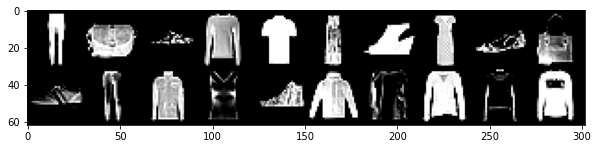

In [ ]:
# visualizing some samples
samples = next(iter(train_loader))
imgs = samples[0]
lbls = samples[1]
plt.figure(figsize=(10,10))
grid = torchvision.utils.make_grid(tensor=imgs[:20], nrow=10)
grid = np.clip(grid,0,1)
plt.imshow(X=np.transpose(grid, axes=(1,2,0)), cmap="gray");

In [ ]:
# train LeNet-5
optimizer = optim.NAdam(params=lenet.parameters())

for epoch in range(5):
    start_time = time.time()
    total_loss = 0
    total_correct = 0
    for batch in train_loader:
        imgs, lbls = batch
    
        preds = lenet(imgs) # get preds
        loss = F.cross_entropy(preds, lbls) # cal loss
        optimizer.zero_grad() # zero gradients
        loss.backward() # calculates gradients 
        optimizer.step() # update the weights
        
        total_loss += loss.item()
        total_correct += get_correct(preds, lbls)
        accuracy = total_correct/len(train_data)
    end_time = time.time() - start_time    
    print(f"😺 epoch {epoch+1} 📈 Train accuracy {accuracy:.3f} "
    f"⏰ epoch_duration {end_time:.2f}, sec "
    f"📉 Train loss:, {total_loss:.2f}")

😺 epoch 1 📈 Train accuracy 0.771 ⏰ epoch_duration 16.97, sec 📉 Train loss:, 150.36
😺 epoch 2 📈 Train accuracy 0.851 ⏰ epoch_duration 16.97, sec 📉 Train loss:, 95.49
😺 epoch 3 📈 Train accuracy 0.870 ⏰ epoch_duration 16.67, sec 📉 Train loss:, 83.20
😺 epoch 4 📈 Train accuracy 0.880 ⏰ epoch_duration 16.85, sec 📉 Train loss:, 76.63
😺 epoch 5 📈 Train accuracy 0.889 ⏰ epoch_duration 17.11, sec 📉 Train loss:, 71.19


In [ ]:
# preds
probs = get_all_preds(data_loader=train_test_loader, model=lenet) # validation on train data
tags = train_data.targets
cm = confusion_matrix(y_true=tags, y_pred=probs.argmax(1))
# plot_confusion_matrix(cm, class_names=train_data.classes, show_normed=True, figsize=(10,10))
# plt.show()

In [ ]:
val_tags = val_data.targets
probs_val = get_all_preds(data_loader=val_test_loader, model=lenet) # validation on held out test set
cm = confusion_matrix(y_true=val_tags, y_pred=probs_val.argmax(1))
# plot_confusion_matrix(cm, class_names=train_data.classes, show_normed=True, figsize=(10,10))

total_correct = get_correct(probs_val, val_tags)
lenet_accuracy = total_correct/len(val_data)
lenet_err = 1 - accuracy
lenet_num_par = sum(p.numel() for p in lenet.parameters())

print(f"💃 LeNet test error is {lenet_err:.3f} with {lenet_num_par} trainable parameters.")

💃 LeNet test error is 0.111 with 62806 trainable parameters.


## ⚡️ Let's compress FC LAYER via training with Skeleton decomposition inside

In [ ]:
# CUSTOM_LAYER

class SkeletonLayer(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, in_features, out_features, rank):
        super().__init__()
        self.in_features, self.out_features, self.rank = in_features, out_features, rank
        v_weights = torch.Tensor(rank, in_features)
        u_weights = torch.Tensor(out_features, rank)
        self.u_weights = nn.Parameter(u_weights)  # nn.Parameter is a Tensor that's a module parameter.
        self.v_weights = nn.Parameter(v_weights)  # nn.Parameter is a Tensor that's a module parameter.
        bias = torch.Tensor(out_features)
        self.bias = nn.Parameter(bias)

        # initialize weights and biases
        bound = 1/(self.in_features*self.rank)
        nn.init.uniform_(self.u_weights, -bound, bound) # weight init
        bound = 1/(self.out_features*self.rank)
        nn.init.uniform_(self.v_weights, -bound, bound) # weight init
        bound = 1/(self.out_features)
        nn.init.uniform_(self.bias, -bound, bound)  # bias init

    def forward(self, x):
        v_times_x = x @ self.v_weights.T
        w_times_x = v_times_x @ self.u_weights.T
        return w_times_x + self.bias  # w times x + b

In [ ]:
# define LeNet-skeleton
r = 32
lenet_skeleton = nn.Sequential()
lenet_skeleton.add_module("conv1", nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2))
lenet_skeleton.add_module("tanh1", nn.Tanh())
lenet_skeleton.add_module("avg_pool1", nn.AvgPool2d(kernel_size=2, stride=2))
lenet_skeleton.add_module("conv2", nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1))
lenet_skeleton.add_module("avg_pool2", nn.AvgPool2d(kernel_size=2, stride=2))
lenet_skeleton.add_module("conv3", nn.Conv2d(in_channels=16, out_channels=128, kernel_size=5,stride=1))
lenet_skeleton.add_module("tanh2", nn.Tanh())
lenet_skeleton.add_module("flatten", nn.Flatten(start_dim=1))
lenet_skeleton.add_module("skeleton1", SkeletonLayer(in_features=128 , out_features=64, rank=r))
lenet_skeleton.add_module("tanh3", nn.Tanh())
lenet_skeleton.add_module("fc2", nn.Linear(in_features=64, out_features=10))
print(lenet_skeleton)

Sequential(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (tanh1): Tanh()
  (avg_pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avg_pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 128, kernel_size=(5, 5), stride=(1, 1))
  (tanh2): Tanh()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (skeleton1): SkeletonLayer()
  (tanh3): Tanh()
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
optimizer = optim.NAdam(params=lenet_skeleton.parameters())

for epoch in range(5):
    start_time = time.time()
    total_loss = 0
    total_correct = 0
    for batch in train_loader:
        imgs, lbls = batch
    
        preds = lenet_skeleton(imgs) # get preds
        loss = F.cross_entropy(preds, lbls) # cal loss
        optimizer.zero_grad() # zero gradients
        loss.backward() # calculates gradients 
        optimizer.step() # update the weights
        lenet_skeleton
        total_loss += loss.item()
        total_correct += get_correct(preds, lbls)
        accuracy = total_correct/len(train_data)
    end_time = time.time() - start_time    
    print(f"Skel Rank {r}. 😺 epoch {epoch+1} 📈 Train accuracy {accuracy:.3f}"
    f" ⏰ epoch_duration {end_time:.2f}, sec"
    f" 📉 Train loss:, {total_loss:.2f}")

Skel Rank 32. 😺 epoch 1 📈 Train accuracy 0.672 ⏰ epoch_duration 17.45, sec 📉 Train loss:, 206.30
Skel Rank 32. 😺 epoch 2 📈 Train accuracy 0.827 ⏰ epoch_duration 24.34, sec 📉 Train loss:, 113.98
Skel Rank 32. 😺 epoch 3 📈 Train accuracy 0.858 ⏰ epoch_duration 19.85, sec 📉 Train loss:, 93.46
Skel Rank 32. 😺 epoch 4 📈 Train accuracy 0.872 ⏰ epoch_duration 16.86, sec 📉 Train loss:, 84.03
Skel Rank 32. 😺 epoch 5 📈 Train accuracy 0.881 ⏰ epoch_duration 17.42, sec 📉 Train loss:, 78.14


(<Figure size 864x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fec7bff5490>)

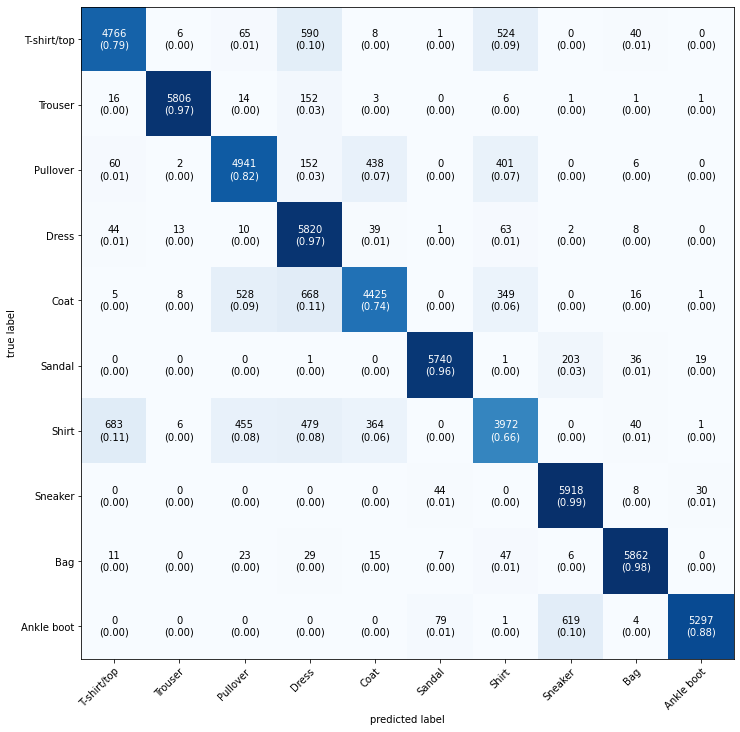

In [ ]:
# preds
probs = get_all_preds(data_loader=train_test_loader, model=lenet_skeleton) # validation on train data
tags = train_data.targets
cm = confusion_matrix(y_true=tags, y_pred=probs.argmax(1))
plot_confusion_matrix(cm, class_names=train_data.classes, show_normed=True, figsize=(12,12))

💃 LeNet with Skeleton-compressed rank 32 FC Layer test error is 0.119 with 60758 trainable parameters.


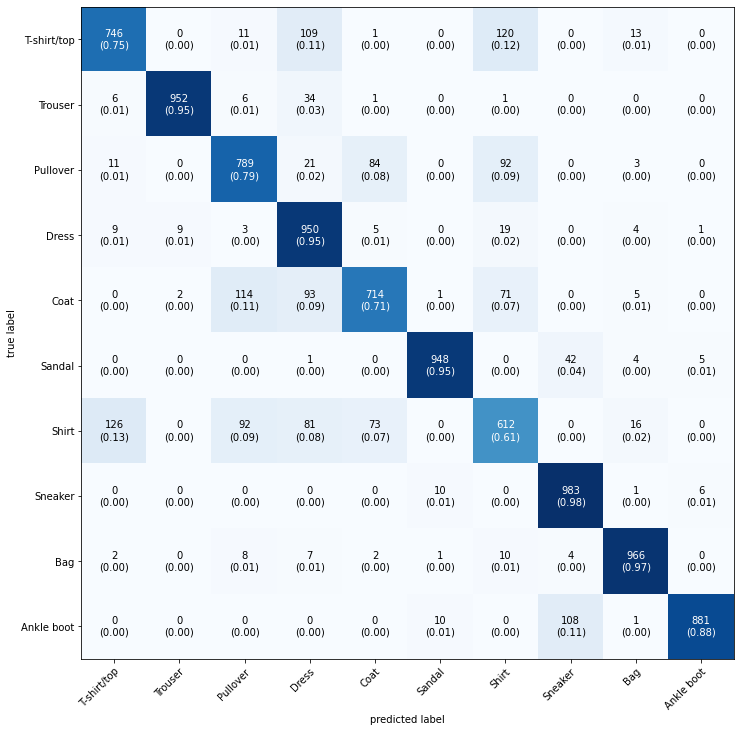

In [ ]:
val_tags = val_data.targets
probs_val = get_all_preds(data_loader=val_test_loader, model=lenet_skeleton) # validation on held out test set
cm = confusion_matrix(y_true=val_tags, y_pred=probs_val.argmax(1))

total_correct = get_correct(probs_val, val_tags)
lenet_accuracy = total_correct/len(val_data)
lenet_skel_err = 1 - accuracy
lenet_skel_num_par = sum(p.numel() for p in lenet_skeleton.parameters())

print(f"💃 LeNet with Skeleton-compressed rank {r} FC Layer test error is "
f"{lenet_skel_err:.3f} with {lenet_skel_num_par} trainable parameters.")

plot_confusion_matrix(cm, class_names=train_data.classes, show_normed=True, figsize=(12,12))
plt.show()

### 🦄 Let's try different ranks

In [ ]:
def run_skeleton_training(rank):
    # define LeNet-skeleton
    model = nn.Sequential()
    model.add_module("conv1", nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2))
    model.add_module("tanh1", nn.Tanh())
    model.add_module("avg_pool1", nn.AvgPool2d(kernel_size=2, stride=2))
    model.add_module("conv2", nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1))
    model.add_module("avg_pool2", nn.AvgPool2d(kernel_size=2, stride=2))
    model.add_module("conv3", nn.Conv2d(in_channels=16, out_channels=128, kernel_size=5,stride=1))
    model.add_module("tanh2", nn.Tanh())
    model.add_module("flatten", nn.Flatten(start_dim=1))
    model.add_module("skeleton1", SkeletonLayer(in_features=128 , out_features=64, rank=rank))
    model.add_module("tanh3", nn.Tanh())
    model.add_module("fc2", nn.Linear(in_features=64, out_features=10))

    # train LeNet-5
    optimizer = optim.NAdam(params=model.parameters())

    for epoch in range(5):
        start_time = time.time()
        total_loss = 0
        total_correct = 0
        for batch in train_loader:
            imgs, lbls = batch
        
            preds = model(imgs) # get preds
            loss = F.cross_entropy(preds, lbls) # cal loss
            optimizer.zero_grad() # zero gradients
            loss.backward() # calculates gradients 
            optimizer.step() # update the weights
            
            total_loss += loss.item()
            total_correct += get_correct(preds, lbls)
            accuracy = total_correct/len(train_data)
        end_time = time.time() - start_time    
        print(f"Skel Rank {rank}. 😺 epoch {epoch+1} 📈 Train accuracy {accuracy:.3f}"
        f" ⏰ epoch_duration {end_time:.2f}, sec"
        f" 📉 Train loss:, {total_loss:.2f}")
 
    val_tags = val_data.targets
    probs_val = get_all_preds(data_loader=val_test_loader, model=model) # validation on held out test set

    total_correct = get_correct(probs_val, val_tags)
    accuracy = total_correct/len(val_data)
    par_num = sum(p.numel() for p in model.parameters())
    return accuracy, par_num

In [ ]:
sk_errs, sk_par_nums = [], []
ranks = np.linspace(1, 64, 10).astype(int)
for rank in ranks:
    rank = int(rank)

    acc, par_num = run_skeleton_training(rank)
    sk_errs.append(1 - acc)
    sk_par_nums.append(par_num)

Skel Rank 1. 😺 epoch 1 📈 Train accuracy 0.417 ⏰ epoch_duration 17.04, sec 📉 Train loss:, 323.10
Skel Rank 1. 😺 epoch 2 📈 Train accuracy 0.674 ⏰ epoch_duration 16.48, sec 📉 Train loss:, 204.49
Skel Rank 1. 😺 epoch 3 📈 Train accuracy 0.737 ⏰ epoch_duration 16.35, sec 📉 Train loss:, 172.65
Skel Rank 1. 😺 epoch 4 📈 Train accuracy 0.758 ⏰ epoch_duration 16.84, sec 📉 Train loss:, 158.33
Skel Rank 1. 😺 epoch 5 📈 Train accuracy 0.784 ⏰ epoch_duration 16.79, sec 📉 Train loss:, 149.49
Skel Rank 8. 😺 epoch 1 📈 Train accuracy 0.613 ⏰ epoch_duration 16.53, sec 📉 Train loss:, 230.90
Skel Rank 8. 😺 epoch 2 📈 Train accuracy 0.787 ⏰ epoch_duration 16.35, sec 📉 Train loss:, 133.19
Skel Rank 8. 😺 epoch 3 📈 Train accuracy 0.831 ⏰ epoch_duration 16.52, sec 📉 Train loss:, 108.41
Skel Rank 8. 😺 epoch 4 📈 Train accuracy 0.857 ⏰ epoch_duration 17.20, sec 📉 Train loss:, 94.46
Skel Rank 8. 😺 epoch 5 📈 Train accuracy 0.868 ⏰ epoch_duration 16.24, sec 📉 Train loss:, 86.40
Skel Rank 15. 😺 epoch 1 📈 Train accuracy 0

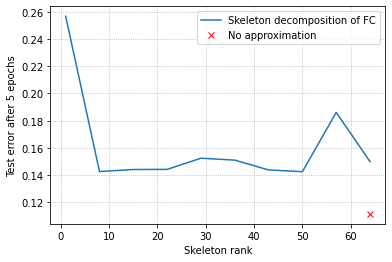

In [ ]:
plt.xlabel("Skeleton rank")
plt.ylabel("Test error after 5 epochs")
plt.plot(ranks, sk_errs, label='Skeleton decomposition of FC')
plt.plot(64, lenet_err, 'rx', label="No approximation")
plt.grid(True, ls=':')
plt.legend()
plt.show()

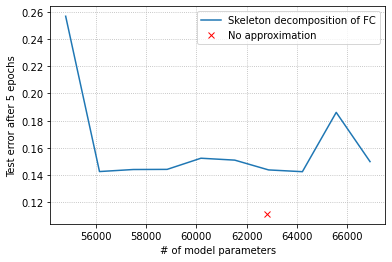

In [ ]:
plt.xlabel("# of model parameters")
plt.ylabel("Test error after 5 epochs")
plt.plot(sk_par_nums, sk_errs, label='Skeleton decomposition of FC')
plt.plot(lenet_num_par, lenet_err, 'rx', label="No approximation")
plt.grid(True, ls=':')
plt.legend()
plt.show()

## 🗜️ Exercise: Compressing FC Layer after Training and Comparing Results

In the previous section, we examined how skeleton decomposition inside the linear layer affected the training process. We trained factors U and V to construct the forward and backward passes. Now, let's consider a scenario where training the model from scratch is not possible. In this section, we will train the model, compress a specific FC layer matrix with a selected rank, and evaluate its performance.

1. Train the LeNet model for 5 epochs. Retrieve the weight matrix from a linear layer, for example, `W = lenet.fc1.weight`.

2. Choose a rank r and compute the best rank r approximation of the matrix $W$, denoted as $W_r$.

3. Set the approximation $W_r$ as the weight matrix for the selected linear layer. Measure the test accuracy of the model with the compressed layer.

4. Experiment with different ranks and create a graph similar to the one in the previous section, illustrating how the test error varies with the selected rank $k$. Compare the performance of the two compression methods on the same graph: training from scratch versus compression after training.

5. EXTRA: Attempt to combine both approaches. First, train the model using the conventional method, then compress the layer. Next, replace the linear layer with a skeleton layer and fine-tune it for 5 epochs. It differs from the seminar in a way, that we use not a random initialization, but, hopefully, good initialization. Plot the same graphs.

In [ ]:
# define LeNet-5
lenet = nn.Sequential()
lenet.add_module("conv1", nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2))
lenet.add_module("tanh1", nn.Tanh())
lenet.add_module("avg_pool1", nn.AvgPool2d(kernel_size=2, stride=2))
lenet.add_module("conv2", nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1))
lenet.add_module("avg_pool2", nn.AvgPool2d(kernel_size=2, stride=2))
lenet.add_module("conv3", nn.Conv2d(in_channels=16, out_channels=128, kernel_size=5,stride=1))
lenet.add_module("tanh2", nn.Tanh())
lenet.add_module("flatten", nn.Flatten(start_dim=1))
lenet.add_module("fc1", nn.Linear(in_features=128 , out_features=64))
lenet.add_module("tanh3", nn.Tanh())
lenet.add_module("fc2", nn.Linear(in_features=64, out_features=10))
print(lenet)

In [ ]:
# train LeNet-5
optimizer = optim.NAdam(params=lenet.parameters())

for epoch in range(5):
    start_time = time.time()
    total_loss = 0
    total_correct = 0
    for batch in train_loader:
        imgs, lbls = batch
    
        preds = lenet(imgs) # get preds
        loss = F.cross_entropy(preds, lbls) # cal loss
        optimizer.zero_grad() # zero gradients
        loss.backward() # calculates gradients 
        optimizer.step() # update the weights
        
        total_loss += loss.item()
        total_correct += get_correct(preds, lbls)
        accuracy = total_correct/len(train_data)
    end_time = time.time() - start_time    
    print(f"😺 epoch {epoch+1} 📈 Train accuracy {accuracy:.3f} "
    f"⏰ epoch_duration {end_time:.2f}, sec "
    f"📉 Train loss:, {total_loss:.2f}")

In [ ]:
W = lenet.fc1.weight